In [2]:
import pandas as pd
from data_reader import read_consumption_and_weather
import torch
import torch.nn as nn
import torch.functional as F
import torch.optim as optim

torch.manual_seed(1)

In [3]:
_, _, df = read_consumption_and_weather()

df1 = df['NO1']
df2 = df['NO2']
df3 = df['NO3']
df4 = df['NO4']
df5 = df['NO5']

Holes by length and occurrences in column NO3:
holes
1        1
dtype: int64
Filling holes up to length 3
Any remaining holes after interpolation? False


In [4]:
print(df.describe())

mba             NO1                         NO2                         NO3  \
        consumption   temperature   consumption   temperature   consumption   
count  50208.000000  50208.000000  50208.000000  50208.000000  50208.000000   
mean    3988.938389      7.929658   4169.734910      9.065414   3097.480634   
std     1311.064087      8.318640    713.038281      5.940013    479.545701   
min     1690.051994    -15.400000   2660.890000    -15.466667   1992.632558   
25%     2914.051405      1.433333   3596.381608      5.033333   2702.097259   
50%     3757.956266      7.800000   4062.967501      9.100000   3067.526689   
75%     4987.063169     14.400000   4699.310916     13.266667   3468.904199   
max     7928.670995     34.400000   6840.053130     32.000000   4756.004039   

mba                           NO4                         NO5                
        temperature   consumption   temperature   consumption   temperature  
count  50208.000000  50208.000000  50208.000000  5020

<AxesSubplot:>

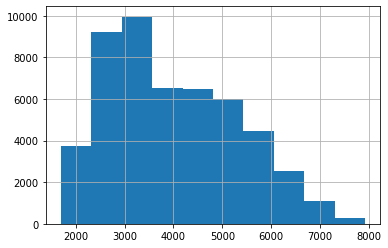

In [7]:
# Explore data
df1['consumption'].hist()